# Rendu Final Projet Fairness en IA

Étudiant 01 : MEDJADJ Mohamed Abderraouf <br>
Étudiant 02 : KERMADJ Zineddine <br>
Groupe : 01 <br>
Parcours : LDD3 Magistère d'Informatique

---

## I. Introduction

### a. Objectif du projet :
L’objectif de ce projet est d’**analyser un sous-ensemble de métadonnées et d’images** du NIH Chest X-ray Dataset, comprenant environ 5300 points de données, afin d’**identifier d’éventuels biais**. Après avoir appliqué une méthode de prétraitement pour **réduire ces biais et améliorer l’équité des données**, nous entraînerons un **modèle de classification d’images**. Enfin, nous analyserons **l’impact de la pondération sur les performances du modèle** ainsi que **l’effet du post-traitement** sur l’atténuation des biais.
### b. Description du dataset :
*Le NIH Chest X-ray Dataset est un vaste ensemble de données médicales comprenant **112 120 images** de radiographies thoraciques issues de **30 805 patients uniques**, avec des étiquettes de maladies générées par traitement automatique du langage naturel (**NLP**) à partir des rapports radiologiques. Ce jeu de données vise à pallier le **manque d’images médicales annotées**, un obstacle majeur au développement de systèmes de diagnostic assisté par ordinateur (CAD) cliniquement pertinents. Les étiquettes sont estimées à plus de **90 % de précision**, rendant cet ensemble adapté à l’apprentissage faiblement supervisé. Avant sa publication, le plus grand jeu de données disponible comptait seulement 4 143 images. Plus de détails sur l’ensemble de données et le processus d’annotation sont disponibles dans l’article en libre accès : « ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases » (Wang et al.).*
### c. Contenu du dataset :
***Image Index** : Identifiant unique pour chaque image. <br>
**Finding Labels** : Diagnostiques associés à l'image (plusieurs diagnostics peuvent être présents). <br>
**Follow-up** # : Le numéro de suivi, indiquant si l'image appartient à un suivi ou à une première consultation. <br>
**Patient ID** : Identifiant unique pour chaque patient. <br>
**Patient Age** : L'âge du patient. <br>
**Patient Gender** : Le genre du patient. <br>
**View Position** : La position de l'image (par exemple, AP pour antéro-postérieur). <br>
**Dimensions et espacements de l'image** : Ces informations peuvent être utiles pour l'analyse des images, mais elles ne semblent pas directement liées à l'identification des biais.*

### SOMMAIRE:
<pre><b>
I.   Introduction
II.    0. Fonctions Utilitaires
II.    1. Préparation des données
II.    2. Analyse des données
II.    3. Identification des biais
III. Application des méthodes de preprocessing
IV.  Application des méthodes de postprocessing
V.   Analyse et compréhension
VI.  Conclusion
</b></pre>

---
# **REMARQUES IMPORTANTES:**
### *a. Les explications des sorties, commentaires des graphiques, etc, sont inclus dans des cellules de **code, et pas markdown**, veuillez donc s'il vous plaît ne pas ignorer les lignes commentées.*

### *b. Pour l'entrainement, veuillez consulter "training.ipynb".*
---

## II.0. Fonctions utilitaires

### a. Import des librairies nécessaires

In [168]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import confusion_matrix
from aif360.datasets import BinaryLabelDataset
from aif360.sklearn.metrics import *
from aif360.algorithms.preprocessing import *
from train_classifieur import train_classifier, pred_classifier
from scipy.sparse import csr_matrix
import random
from IPython.display import Image, display
from PIL import Image
from IPython.display import Image as IPImage, display
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from aif360.metrics import ClassificationMetric
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.postprocessing import RejectOptionClassification

### b. Les fonctions utilitaires

In [131]:
# Fonction pour le calcul des métriques de fairness

def get_group_metrics(
    y_true,
    y_pred=None,
    prot_attr=None,
    priv_group=1,
    pos_label=1,
    sample_weight=None,
):
    group_metrics = {}
    group_metrics["base_rate"] = base_rate(
        y_true=y_true, pos_label=pos_label, sample_weight=sample_weight
    )
    group_metrics["statistical_parity_difference"] = statistical_parity_difference(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
    )
    group_metrics["disparate_impact_ratio"] = disparate_impact_ratio(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
    )
    if not y_pred is None:
        group_metrics["equal_opportunity_difference"] = equal_opportunity_difference(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["average_odds_difference"] = average_odds_difference(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["conditional_demographic_disparity"] = conditional_demographic_disparity(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["smoothed_edf"] = smoothed_edf(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["df_bias_amplification"] = df_bias_amplification(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
    return group_metrics

In [132]:
# Fonction pour tracer des matrices de confusion

def plot_confusion_matrix(y_true, y_pred, labels=["sain", "malade"], normalize=False, title="Matrice de confusion"):
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / len(y_true) * 100
    
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    fig = px.imshow(cm_df, 
                    labels=dict(x="Prédiction", y="Vérité", color="Fréquence (%)" if normalize else "Fréquence"), 
                    x=labels, 
                    y=labels, 
                    color_continuous_scale='Blues',
                    range_color=[0, 100] if normalize else None) 
    
    for i in range(len(cm_df)):
        for j in range(len(cm_df.columns)):
            fig.add_annotation(
                x=j,
                y=i,
                text=f'{cm_df.iloc[i, j]:.2f}%' if normalize else f'{cm_df.iloc[i, j]}',
                showarrow=False,
                font=dict(color="black", size=14),
                align="center"
            )
    
    fig.update_layout(title=title, xaxis_title="Prédiction", yaxis_title="Vérité")
    fig.show()

In [133]:
# Fonction pour afficher des matrices de confusion séparées pour chaque groupe défini par group_columns
def plot_confusion_matrix_by_group(y_true, y_pred, df, group_columns, labels=None, normalize=False):
    for group_value, group_df in df.groupby(group_columns):
        y_true_group = y_true[group_df.index]
        y_pred_group = y_pred[group_df.index]
        
        print(f"Matrice de confusion pour {group_columns}: {group_value}")
        plot_confusion_matrix(y_true_group, y_pred_group, labels, normalize, title=f"Matrice de Confusion ({group_columns}={group_value})")


## II.1. Preparation des données

### a. Chargement du dataset

In [134]:
DATA_DIR = "./DATA"
PREDS_DIR = "./expe_log"
df = pd.read_csv(PREDS_DIR+"/preds.csv")

### b. Exploration préliminaire

In [135]:
print(df.shape)
# Affichons les 5 premiers points de donnée du dataset
df.head()

(10948, 16)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],WEIGHTS,preds,logits_0,logits_1,labels
0,00000028_000.png,Pleural_Thickening,0,28,63,M,PA,2048,2500,0.168000,0.168000,1,sain,0.377295,0.622705,malade
1,00000037_000.png,No Finding,0,37,72,M,PA,2708,2638,0.143000,0.143000,1,sain,0.214857,0.785143,sain
2,00000044_000.png,Consolidation|Effusion|Infiltration,0,44,79,M,PA,2010,2021,0.194311,0.194311,1,malade,0.714177,0.285823,malade
3,00000044_001.png,Infiltration|Pleural_Thickening,1,44,78,M,PA,2544,3056,0.139000,0.139000,1,malade,0.787916,0.212084,malade
4,00000044_002.png,Cardiomegaly,2,44,78,M,PA,3056,2544,0.139000,0.139000,1,malade,0.728035,0.271965,malade


In [136]:
# Vérifions les types de données et les valeurs manquantes
df.info()

# Explication des sorties:
# Le dataset est composé de 12 colonnes, dont 8 correspondent à des features numériques, et 4 catégorielles.
# Toutes les colonnes ne contiennent pas de valeurs nulles sauf la dernière (Unnamed: 11), qui contient que des valeurs nulles.
# Le dataset contient 54009 points de données.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10948 entries, 0 to 10947
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  10948 non-null  object 
 1   Finding Labels               10948 non-null  object 
 2   Follow-up #                  10948 non-null  int64  
 3   Patient ID                   10948 non-null  int64  
 4   Patient Age                  10948 non-null  int64  
 5   Patient Gender               10948 non-null  object 
 6   View Position                10948 non-null  object 
 7   OriginalImage[Width          10948 non-null  int64  
 8   Height]                      10948 non-null  int64  
 9   OriginalImagePixelSpacing[x  10948 non-null  float64
 10  y]                           10948 non-null  float64
 11  WEIGHTS                      10948 non-null  int64  
 12  preds                        10948 non-null  object 
 13  logits_0        

In [137]:
# Statistiques descriptives
df.describe()

# Explication des sorties:
# Max: On remarque qu'il y a une valeur max = 412 pour l'age, qui n'est pas normal (outlier), et qui peut être dû à une erreur de frappe.
# Count = nombre de points de données sauf pour 'Unnamed: 11', cette colonne contient que des null.
# Mean: Moyenne des valeurs par colonne, pas de remarque importante.
# Std: Standard deviation des valeurs par colonne, pas de remarque importante.
# Min: Le min des valeurs par colonne, pas de remarque importante.
# Les Quantiles: pas de remarque importante.

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],WEIGHTS,logits_0,logits_1
count,10948.000000,10948.000000,10948.000000,10948.000000,10948.000000,10948.000000,10948.000000,10948.0,10948.000000,10948.000000
mean,8.047497,14060.749817,45.946840,2655.447662,2493.314487,0.155255,0.155255,1.0,0.523850,0.476150
std,12.626621,8588.887031,17.864949,339.587310,401.468117,0.016136,0.016136,0.0,0.198824,0.198824
min,0.000000,13.000000,1.000000,1282.000000,1153.000000,0.115000,0.115000,1.0,0.074622,0.062328
25%,0.000000,7018.000000,33.000000,2500.000000,2048.000000,0.143000,0.143000,1.0,0.356488,0.306754
50%,3.000000,13890.000000,48.000000,2544.000000,2544.000000,0.143000,0.143000,1.0,0.529420,0.470580
75%,10.000000,20675.000000,58.000000,2992.000000,2991.000000,0.168000,0.168000,1.0,0.693246,0.643512
max,80.000000,30803.000000,412.000000,3451.000000,3056.000000,0.194323,0.194323,1.0,0.937672,0.925378


### c. Préparation du dataset

In [138]:
# On sauvegarde le dataframe original avant toute transformation
original_df = df.copy()

In [139]:
# Fonction pour faire des train-test split:

def train_test_split(df):
    train_sain_path = DATA_DIR+"/train/sain"
    train_malade_path = DATA_DIR+"/train/malade"

    train_images = set(os.listdir(train_sain_path) + os.listdir(train_malade_path))

    df["in_train"] = df["Image Index"].apply(lambda x: 1 if x in train_images else 0)

In [140]:
# Élimination des outliers (age > 130 years old)
df = df[df['Patient Age'] <= 130]

# Séparation des données train-test
train_test_split(df)

# Séparation des colonnes liées aux images des autres métadonnées
df_image_related = df[['Image Index', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'View Position']]
df_others = df.drop(columns=['Image Index', 
    'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'View Position'])

# Encodage de 'preds' et 'labels' en binaire
df_others["preds"] = df_others["preds"].map({"sain": 0, "malade": 1}) 
df_others["labels"] = df_others["labels"].map({"sain": 0, "malade": 1})

# Déplacement du label 'Finding Labels' à la fin du dataframe.
df_others = df_others[[col for col in df_others.columns if col != 'Finding Labels'] + ['Finding Labels']]
df_original_label = df_others[['Finding Labels']]

print(df_others.shape)
# On remarque que le nombre de points de données a diminué de 6 (outliers eliminés).

df_others.head()

(10945, 11)


,Follow-up #,Patient ID,Patient Age,Patient Gender,WEIGHTS,preds,logits_0,logits_1,labels,in_train,Finding Labels
0,0,28,63,M,1,0,0.377295,0.622705,1,0,Pleural_Thickening
1,0,37,72,M,1,0,0.214857,0.785143,0,1,No Finding
2,0,44,79,M,1,1,0.714177,0.285823,1,1,Consolidation|Effusion|Infiltration
3,1,44,78,M,1,1,0.787916,0.212084,1,1,Infiltration|Pleural_Thickening
4,2,44,78,M,1,1,0.728035,0.271965,1,1,Cardiomegaly


In [141]:
# VERSION 1: encodage one-hot du label

# a. Création d'une colonne 'Finding Labels' contenant une liste des labels
df_encoded_OH = df_others.copy()
df_encoded_OH['Finding Labels'] = df_encoded_OH['Finding Labels'].replace('No Finding', '').str.split('|')
df_encoded_OH['Finding Labels'] = df_encoded_OH['Finding Labels'].apply(lambda x: [] if x == [''] else x)

# b. Encodage des colonnes en One-Hot avec le prefix "Finding_"
all_labels = set([label for sublist in df_encoded_OH['Finding Labels'] for label in sublist])
for label in all_labels:
    column_name = f"Finding_{label.lower().replace(' ', '_')}"
    df_encoded_OH[column_name] = df_encoded_OH['Finding Labels'].apply(lambda x: 1 if label in x else 0)
df_encoded_OH = df_encoded_OH.drop(columns=['Finding Labels'])

df_encoded_OH

,Follow-up #,Patient ID,Patient Age,Patient Gender,WEIGHTS,preds,logits_0,logits_1,labels,in_train,...,Finding_mass,Finding_fibrosis,Finding_atelectasis,Finding_pneumonia,Finding_hernia,Finding_edema,Finding_emphysema,Finding_pleural_thickening,Finding_infiltration,Finding_effusion
0,0,28,63,M,1,0,0.377295,0.622705,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0,37,72,M,1,0,0.214857,0.785143,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,44,79,M,1,1,0.714177,0.285823,1,1,...,0,0,0,0,0,0,0,0,1,1
3,1,44,78,M,1,1,0.787916,0.212084,1,1,...,0,0,0,0,0,0,0,1,1,0
4,2,44,78,M,1,1,0.728035,0.271965,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10943,10,30753,55,F,1,1,0.612217,0.387783,1,1,...,0,0,1,0,0,0,0,0,0,1
10944,11,30753,54,F,1,1,0.614865,0.385135,1,1,...,1,0,0,0,0,0,0,0,0,0
10945,12,30753,55,F,1,0,0.476207,0.523793,1,1,...,1,0,1,0,0,0,0,0,0,0
10946,0,30782,40,M,1,0,0.374613,0.625387,0,1,...,0,0,0,0,0,0,0,0,0,0


In [142]:
# VERSION 2: encodage binaire (1 ssi patient malade) du label

df_encoded_bool = df_others.copy()
df_encoded_bool = df_encoded_bool.drop(columns=['Finding Labels'])

df_encoded_bool

,Follow-up #,Patient ID,Patient Age,Patient Gender,WEIGHTS,preds,logits_0,logits_1,labels,in_train
0,0,28,63,M,1,0,0.377295,0.622705,1,0
1,0,37,72,M,1,0,0.214857,0.785143,0,1
2,0,44,79,M,1,1,0.714177,0.285823,1,1
3,1,44,78,M,1,1,0.787916,0.212084,1,1
4,2,44,78,M,1,1,0.728035,0.271965,1,1
...,...,...,...,...,...,...,...,...,...,...
10943,10,30753,55,F,1,1,0.612217,0.387783,1,1
10944,11,30753,54,F,1,1,0.614865,0.385135,1,1
10945,12,30753,55,F,1,0,0.476207,0.523793,1,1
10946,0,30782,40,M,1,0,0.374613,0.625387,0,1


## II.2. Analyse des données

### 0. Séparation du label, des features numériques et catégorielles

In [143]:
df_encoded = df_encoded_OH
df_encoded.dtypes
# Toutes les features sont numériques, sauf le genre (sexe)

Follow-up #                     int64
Patient ID                      int64
Patient Age                     int64
Patient Gender                 object
WEIGHTS                         int64
preds                           int64
logits_0                      float64
logits_1                      float64
labels                          int64
in_train                        int64
Finding_nodule                  int64
Finding_pneumothorax            int64
Finding_consolidation           int64
Finding_cardiomegaly            int64
Finding_mass                    int64
Finding_fibrosis                int64
Finding_atelectasis             int64
Finding_pneumonia               int64
Finding_hernia                  int64
Finding_edema                   int64
Finding_emphysema               int64
Finding_pleural_thickening      int64
Finding_infiltration            int64
Finding_effusion                int64
dtype: object

In [144]:
# Séparation du label, des features numériques et catégorielles
one_hot_label = [col for col in df_encoded.columns if col.startswith("Finding")] # pour la version 1 de l'encodage
boolean_label = 'labels' # pour la version 2 de l'encodage

numerical_features = list(set(df_encoded.select_dtypes(include=np.number).columns) - set(one_hot_label))
categorical_features = list(set(df_encoded.columns) - set(numerical_features) - set(one_hot_label))

### Analyse univariée

### a. Analyse de la corrélation (Feature-Label et Feature-Feature)

In [145]:
# Fonction qui calcule la corrélation linéaire entre deux features
def compute_correlation(df, cola, colb):
  return np.corrcoef(df[cola].values, df[colb].values)[0][1]

In [146]:
# Calcul des corrélations entre les features et les colonnes du label (one-hot) (Feature-Label).
for num_feature in numerical_features:
  if num_feature not in {"labels", "preds", "in_train"}:
    for label_col in one_hot_label:
      corr = compute_correlation(df_encoded, label_col, num_feature)
      if np.abs(corr) > 0.05 :
        print(num_feature, label_col, corr)

## On n'affiche que les couples de features qui ont une corrélation (valeur absolue) supérieure à 0.05
## Comme on le voit, il s'agit de très faibles corrélations (pas de biais linéaire)

Follow-up # Finding_pneumothorax 0.12146884779215618
Follow-up # Finding_consolidation 0.09559175729276258
Follow-up # Finding_pneumonia 0.06154454513685243
Follow-up # Finding_edema 0.09379031031047198
Follow-up # Finding_emphysema 0.09083054962124346
Follow-up # Finding_infiltration 0.1662814496871187
Follow-up # Finding_effusion 0.08326374552525646
logits_0 Finding_nodule 0.07797863506794595
logits_0 Finding_pneumothorax 0.1590909724537048
logits_0 Finding_consolidation 0.15123437880191662
logits_0 Finding_cardiomegaly 0.06308908988773276
logits_0 Finding_mass 0.0766331113906877
logits_0 Finding_atelectasis 0.18197851394038447
logits_0 Finding_pneumonia 0.07604196030150281
logits_0 Finding_edema 0.1110869756570385
logits_0 Finding_emphysema 0.11048445065568187
logits_0 Finding_pleural_thickening 0.10664952143749175
logits_0 Finding_infiltration 0.1848026580368397
logits_0 Finding_effusion 0.29212284674877403
Patient Age Finding_atelectasis 0.06758255526526569
Patient Age Finding_emp

c:\Users\zizou\projet-fairness\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning:

invalid value encountered in divide

c:\Users\zizou\projet-fairness\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning:

invalid value encountered in divide



In [147]:
# Calcul des corrélations entre les features et les colonnes du label (booléen) (Feature-Label).
for num_feature in numerical_features:
    if num_feature not in {"labels", "preds", "in_train"}:
        corr = compute_correlation(df_encoded_bool, boolean_label, num_feature)
        if np.abs(corr) > 0.05 :
            print(num_feature, boolean_label, corr)

## On n'affiche que les couples de features qui ont une corrélation (valeur absolue) supérieure à 0.05
## Comme on le voit, il s'agit de très faibles corrélations (pas de biais linéaire)

Follow-up # labels 0.18639063320858537
logits_0 labels 0.3957492134689194
logits_1 labels -0.39574921435557703


In [148]:
# Calcul des corrélations entre les features (Feature-Feature).
for num_feature in numerical_features:
  if num_feature not in {"labels", "preds", "in_train"}:
    for num_feature2 in (set(numerical_features)-set([num_feature])):
      if num_feature2 not in {"labels", "preds", "in_train"}:
        corr = compute_correlation(df_encoded, num_feature, num_feature2)
        if np.abs(corr) > 0.05 :
          print(num_feature, num_feature2, corr)

## On n'affiche que les couples de features qui ont une corrélation (valeur absolue) supérieure à 0.05
## Comme on le voit, il s'agit de très faibles corrélations (pas de biais linéaire)

Follow-up # logits_0 0.34182068301810675
Follow-up # Patient Age -0.177831955346902
Follow-up # logits_1 -0.341820679181076
logits_0 Follow-up # 0.3418206830181067
logits_0 Patient Age 0.07605656234003667
logits_0 logits_1 -0.9999999999999817
Patient Age Follow-up # -0.17783195534690202
Patient Age logits_0 0.07605656234003667
Patient Age logits_1 -0.07605656617147791
Patient Age Patient ID -0.09838140945159148
logits_1 Follow-up # -0.34182067918107595
logits_1 logits_0 -0.9999999999999817
logits_1 Patient Age -0.07605656617147791
Patient ID Patient Age -0.09838140945159148


### b. Analyse des biais liés au sexe

In [149]:
fig = px.pie(df_encoded, names="Patient Gender", title="Distribution du sexe")
fig.show()

# Explication des sorties:
# On remarque que le nombre de points de données 'masculin' est plus élevé que celui des 'féminin', 
# ce qui pourrait indiquer une sous-représentation des femmes dans le dataset.

In [150]:
fig = px.histogram(df_encoded_bool, x='Patient Gender', color=boolean_label, \
                  title=f"{'Patient Gender'} distribution by {boolean_label}")
fig.show()

# Explication des sorties:
# On remarque que la distribution du sexe selon 'is_ill' est balancée (50% malade, 50% non malade, dans les deux sexes).
# Donc on est bon vis-à-vis de ça.

In [151]:
gender_col_bool = (df_encoded_bool['Patient Gender'] == 'M') # Conversion {'F' -> 0, 'M' -> 1}

def calc_dir_gender(df, label):
    dir = disparate_impact_ratio(
        y_true=df[label],
        prot_attr=gender_col_bool,
        pos_label=0
    )
    return dir

print("global_is_ill", calc_dir_gender(df_encoded_bool, boolean_label))

# Explication des sorties:
# DIR ~ 1, donc pas de biais pas de classe (M/F) favorisée vis-à-vis le label 'is_ill'.

global_is_ill 1.0808016249171342


In [152]:
def display_categorical_hist(df, cat_feature, target):
  fig = px.histogram(df, x=cat_feature, color=target)
  fig.show()

def display_categorical_hist_percent(df, cat_feature, target):
  if cat_feature != "labels" and cat_feature != "preds" :
    df_summarized = df.groupby([target,cat_feature]).agg("count").reset_index()
    df_summarized[f"percent of {cat_feature}"] = df_summarized[[cat_feature,"Patient Age"]].apply(
      lambda x: 100*x["Patient Age"]/df_summarized[df_summarized[cat_feature]==x[cat_feature]]["Patient Age"].sum(), axis=1
    )
    df_summarized[target] = df_summarized[target].astype(str)
    fig = px.bar(df_summarized, x=f"{cat_feature}", y=f"percent of {cat_feature}", color=target)
    fig.show()

In [153]:
for cat_feature in categorical_features:
  for label_col in one_hot_label:
    display_categorical_hist_percent(df_encoded, cat_feature, label_col)

# Explication des sorties:
# En général, il n'y a pas de classe favorisée, la distribution de chaque pathologie est similaire sur les deux sexes.
# Mais on remarque qu'il y a des maladies sous-représentées, confirmons cela avec la visualisation suivante (partie 3.c).

In [154]:
for label_col in one_hot_label:
    dir = calc_dir_gender(df_encoded, label_col)
    print(label_col, dir)

# Explication des sorties:
# Tous les DIRs calculés sont ~ 1, donc pas de biais pas de classe (M/F) favorisée vis-à-vis les labels one-hot.

Finding_nodule 0.9926621032525749
Finding_pneumothorax 1.0011909883877268
Finding_consolidation 0.9991613907096738
Finding_cardiomegaly 0.9945284592456114
Finding_mass 1.0078645393778163
Finding_fibrosis 1.0006516022433734
Finding_atelectasis 1.0421801651214198
Finding_pneumonia 1.0020524596806244
Finding_hernia 0.9990503918673429
Finding_edema 1.001395134627653
Finding_emphysema 1.0088672152574247
Finding_pleural_thickening 1.0090622991876883
Finding_infiltration 1.034114665538991
Finding_effusion 1.0071418956427085


### c. Analyse des biais liés à la distribution des labels (one-hot)

In [155]:
category_counts = df_encoded[one_hot_label].sum()
fig = px.bar(
    x=category_counts.index,
    y=category_counts.values,
    labels={'x': 'Disease Type', 'y': 'Count of 1s'},
    title='Distribution of One-Hot Encoded Labels'
)
fig.show()

# Explication des sorties:
# On remarque une distribution non équilibrée sur les différentes maladies, ce qui peut induire un modèle biaisé.
# Solution: introduire des weights, détaillons ça après.

### d. Analyse des biais liés à l'age

In [156]:
fig = px.box(df_encoded_bool, x=boolean_label, y='Patient Age', title=f"age distribution by {boolean_label}")
fig.show()

fig = px.histogram(df_encoded_bool, x='Patient Age', color=boolean_label, barmode="overlay", \
                  title=f"age distribution by {boolean_label}")
fig.show()

# Explication des sorties:
# On remarque que 50% des patients qui sont condensés au mileu ~[30ans -> 65ans].
# Les distributions d'age sur les deux classes (malade/non malade) sont similaires.
# Mais on pourrait argumenter que les catégories d'age ~[0 - 30 ans] et ~[65+ ans], sont sous-représentés.
# Pour le confirmer, passons au graphique suivant (Discretisation d'age).

In [157]:
# Discretisation de l'age
discrete_age = {}
discrete_age['age_group'] = pd.cut(df_encoded_bool['Patient Age'], bins=[0, 30, 65, 130], labels=['0-30', '30-65', '65+'], right=True)
df_encoded_bool['age_group'] = discrete_age['age_group']
fig = px.histogram(discrete_age, x='age_group', title='Distribution des classes d\'age',
                   labels={'age_group': 'Classes d\'age'}, 
                   text_auto=True)
fig.show()

# Explication des sorties:
# Voilà, on voit bien le deséquilibre dans la distribution des classes d'age, les classes '0-30' et '65+' sont sous-représentées
# en comparaison avec '30-65', d'où la présence d'un potentiel biais lié à ça.

In [158]:
# Determinons le unpriviliged group



In [159]:
# On encode les classes d'age en booléen comme suit:

df_encoded_bool["age_30_65"] = (df_encoded_bool['age_group'] == '30-65').astype(int)
df_encoded_bool = df_encoded_bool.drop(columns=['age_group'])
df_encoded_bool

,Follow-up #,Patient ID,Patient Age,Patient Gender,WEIGHTS,preds,logits_0,logits_1,labels,in_train,age_30_65
0,0,28,63,M,1,0,0.377295,0.622705,1,0,1
1,0,37,72,M,1,0,0.214857,0.785143,0,1,0
2,0,44,79,M,1,1,0.714177,0.285823,1,1,0
3,1,44,78,M,1,1,0.787916,0.212084,1,1,0
4,2,44,78,M,1,1,0.728035,0.271965,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
10943,10,30753,55,F,1,1,0.612217,0.387783,1,1,1
10944,11,30753,54,F,1,1,0.614865,0.385135,1,1,1
10945,12,30753,55,F,1,0,0.476207,0.523793,1,1,1
10946,0,30782,40,M,1,0,0.374613,0.625387,0,1,1


### e. Analyse des biais liés au "Patient ID"

In [160]:
fig = px.box(df_encoded_bool, x=boolean_label, y='Patient ID', title=f"patient_id distribution by {boolean_label}")
fig.show()

fig = px.histogram(df_encoded_bool, x='Patient ID', color=boolean_label, \
                  title=f"patient_id distribution by {boolean_label}")
fig.show()

# Explication des sorties:
# On peut dire de la première figure que la distribution des patient_id est similaire sur les deux classes (malade/non malade).
# On peut même dire que la distribution est pseudo-uniforme.
# Mais en regardant le deuxième graphique, on remarque une petite anomalie au voisinage de l'id 25000, 
# et qui peut biaiser le modèle.

### Analyse bivariée

### f. Analyse (bivariée) des biais liés au 'Follow-up'

In [161]:
# Fig 01
fig = px.histogram(df_encoded, x="Patient ID", y="Follow-up #", title="Distribution du nombre de suivis")
fig.show()

# Fig 02
fig = px.histogram(df_encoded, x="Patient Gender", y="Follow-up #", title="Nombre de suivis par genre")
fig.show()

# Fig 03
fig = px.histogram(df_encoded, x="Patient Age", y="Follow-up #", title="Relation entre l’âge et le nombre de suivis")
fig.show()

# Fig 03
df_melted = df_encoded.melt(id_vars=["Follow-up #"], value_vars=[col for col in df_encoded.columns if "Finding_" in col], 
                     var_name="disease", value_name="presence")
df_melted = df_melted[df_melted["presence"] == 1]

# Fig 04
fig = px.histogram(df_melted, x="disease", y="Follow-up #", title="Nombre de suivis par maladie")
fig.show()


# Explication des sorties:
# Fig 01: Deux petites anomalies au voisinage des IDs 10000 (pic très marqué du nombre de suivis) et 25000 (forte baisse, presque à zéro), 
# cela peut biaiser le modèle quand on prédit des valeurs à ces voisinages.
# Fig 02: Même remarque que dans l'étude des biais liés au sexe (b).
# Fig 03: Même remarque que dans l'étude des biais liés à l'age (d).
# Fig 04: Même remarque que dans l'étude des biais liés à la distribution des labels one-hot (c).

In [165]:
finding_columns = [col for col in df_encoded.columns if col.startswith("Finding")]

sparse_matrix = csr_matrix(df_encoded[finding_columns].values)

co_occurrence_matrix = sparse_matrix.T @ sparse_matrix

total_occurrences = np.array(sparse_matrix.sum(axis=0)).flatten()
probability_matrix = co_occurrence_matrix.toarray() / total_occurrences

co_occurrence_df = pd.DataFrame(co_occurrence_matrix.toarray(), index=finding_columns, columns=finding_columns)
probability_df = pd.DataFrame(probability_matrix, index=finding_columns, columns=finding_columns)

def display_matrix(df, title):
    return df.style.background_gradient(cmap="Blues", axis=None).set_caption(title)

styled_co_occurrence_df = display_matrix(co_occurrence_df, "Matrice de Co-Occurrence")
styled_probability_df = display_matrix(probability_df, "Matrice de Probabilités Conditionnelles")

print("Matrice de co-occurrence:")
display(styled_co_occurrence_df)

print("\nMatrice de probabilités conditionnelles:")
display(styled_probability_df)


Matrice de co-occurrence:


,Finding_nodule,Finding_pneumothorax,Finding_consolidation,Finding_cardiomegaly,Finding_mass,Finding_fibrosis,Finding_atelectasis,Finding_pneumonia,Finding_hernia,Finding_edema,Finding_emphysema,Finding_pleural_thickening,Finding_infiltration,Finding_effusion
Finding_nodule,602,30,52,13,75,21,41,3,1,15,13,37,169,78
Finding_pneumothorax,30,504,26,10,40,8,69,4,0,3,77,36,96,102
Finding_consolidation,52,26,437,16,42,9,90,19,1,16,8,18,106,99
Finding_cardiomegaly,13,10,16,274,9,5,41,9,1,14,11,11,63,105
Finding_mass,75,40,42,9,523,8,68,2,3,12,17,39,92,102
Finding_fibrosis,21,8,9,5,8,187,23,2,1,0,4,23,31,20
Finding_atelectasis,41,69,90,41,68,23,1069,28,3,25,39,39,306,270
Finding_pneumonia,3,4,19,9,2,2,28,154,0,38,7,6,64,30
Finding_hernia,1,0,1,1,3,1,3,0,21,0,0,2,1,1
Finding_edema,15,3,16,14,12,0,25,38,0,251,7,6,103,51



Matrice de probabilités conditionnelles:


,Finding_nodule,Finding_pneumothorax,Finding_consolidation,Finding_cardiomegaly,Finding_mass,Finding_fibrosis,Finding_atelectasis,Finding_pneumonia,Finding_hernia,Finding_edema,Finding_emphysema,Finding_pleural_thickening,Finding_infiltration,Finding_effusion
Finding_nodule,1.000000,0.059524,0.118993,0.047445,0.143403,0.112299,0.038354,0.019481,0.047619,0.059761,0.047101,0.115987,0.088574,0.068361
Finding_pneumothorax,0.049834,1.000000,0.059497,0.036496,0.076482,0.042781,0.064546,0.025974,0.000000,0.011952,0.278986,0.112853,0.050314,0.089395
Finding_consolidation,0.086379,0.051587,1.000000,0.058394,0.080306,0.048128,0.084191,0.123377,0.047619,0.063745,0.028986,0.056426,0.055556,0.086766
Finding_cardiomegaly,0.021595,0.019841,0.036613,1.000000,0.017208,0.026738,0.038354,0.058442,0.047619,0.055777,0.039855,0.034483,0.033019,0.092025
Finding_mass,0.124585,0.079365,0.096110,0.032847,1.000000,0.042781,0.063611,0.012987,0.142857,0.047809,0.061594,0.122257,0.048218,0.089395
Finding_fibrosis,0.034884,0.015873,0.020595,0.018248,0.015296,1.000000,0.021515,0.012987,0.047619,0.000000,0.014493,0.072100,0.016247,0.017528
Finding_atelectasis,0.068106,0.136905,0.205950,0.149635,0.130019,0.122995,1.000000,0.181818,0.142857,0.099602,0.141304,0.122257,0.160377,0.236635
Finding_pneumonia,0.004983,0.007937,0.043478,0.032847,0.003824,0.010695,0.026193,1.000000,0.000000,0.151394,0.025362,0.018809,0.033543,0.026293
Finding_hernia,0.001661,0.000000,0.002288,0.003650,0.005736,0.005348,0.002806,0.000000,1.000000,0.000000,0.000000,0.006270,0.000524,0.000876
Finding_edema,0.024917,0.005952,0.036613,0.051095,0.022945,0.000000,0.023386,0.246753,0.000000,1.000000,0.025362,0.018809,0.053983,0.044698


### Analyse d'images

La principale nouveauté depuis le mi-projet est l’intégration d’images dans le dataset. Cependant, ces nouvelles données peuvent introduire de nouveaux biais, tels qu’une faible luminosité, la présence de dispositifs médicaux intra-corporels, ou d'autres artefacts visuels susceptibles d’influencer l’analyse.

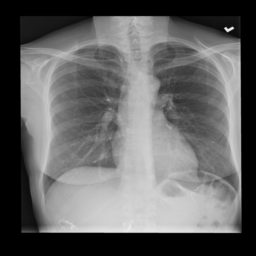

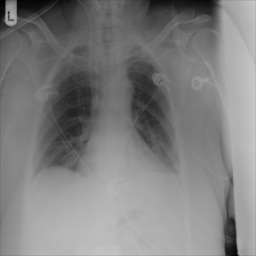

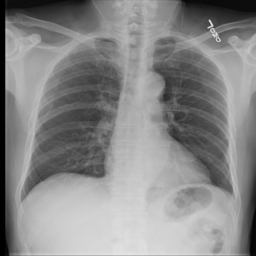

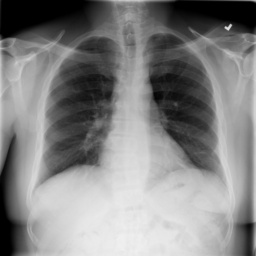

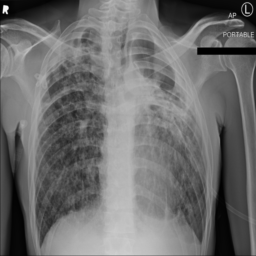

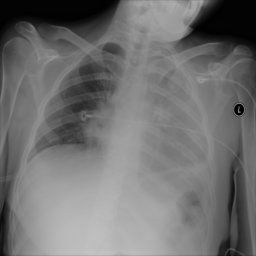

In [ ]:
import os
import random
from IPython.display import Image, display

# Liste de chemins vers tes dossiers (paths)
paths = [
    "DATA/train/sain",
    "DATA/train/malade",
    "DATA/valid/sain",
    "DATA/valid/malade",
]

# Récupère tous les fichiers .png dans les dossiers
toutes_les_images = []
for path in paths:
    if os.path.exists(path):
        images = [os.path.join(path, f) for f in os.listdir(path) if f.lower().endswith('.png')]
        toutes_les_images.extend(images)

# Choisir un certain nombre d'images aléatoires (par exemple 6)
nombre_images = 6
images_choisies = random.sample(toutes_les_images, min(nombre_images, len(toutes_les_images)))

# Affiche les images dans le notebook
for chemin in images_choisies:
    display(Image(filename=chemin))


In [ ]:
from PIL import Image
from IPython.display import Image as IPImage, display

# Fonction pour calculer la luminosité moyenne d'une image
def calculer_luminosite(image_path):
    # Ouvrir l'image
    img = Image.open(image_path)
    
    # Convertir l'image en niveaux de gris (pour analyser la luminosité)
    grayscale_img = img.convert("L")
    
    # Convertir l'image en un tableau numpy
    img_array = np.array(grayscale_img)
    
    # Calculer la luminosité moyenne de l'image
    luminosite_moyenne = np.mean(img_array)
    
    return luminosite_moyenne

# Fonction pour récupérer toutes les images dans un répertoire
def recuperer_images_du_repertoire(dossier):
    images = []
    for file in os.listdir(dossier):
        if file.lower().endswith('.png'):  # Seulement les fichiers .png
            images.append(os.path.join(dossier, file))
    return images

# Variable pour stocker les images à faible et forte luminosité
images_faible_luminosite = []
images_forte_luminosite = []

# Pour chaque dossier, récupérer toutes les images et choisir celle ayant la plus faible luminosité
for path in paths:
    if os.path.exists(path):
        # Récupérer toutes les images du dossier
        images = recuperer_images_du_repertoire(path)
        
        if images:
            # Calculer la luminosité pour chaque image
            luminosites = [(image, calculer_luminosite(image)) for image in images]
            
            # Trouver l'image avec la luminosité la plus faible
            image_min_luminosite = min(luminosites, key=lambda x: x[1])
            image_max_luminosite = max(luminosites, key=lambda x: x[1])
            
            # Ajouter l'image à faible et forte luminosité à la liste
            images_faible_luminosite.append(image_min_luminosite[0])
            images_forte_luminosite.append(image_max_luminosite[0])

# Affichage des images à faible luminosité
for chemin in images_faible_luminosite:
    display(IPImage(filename=chemin))
    
for chemin in images_forte_luminosite:
    display(IPImage(filename=chemin))


In [ ]:
def foreground_filter(gris, threshold):
    """
    Retourne un masque booléen indiquant quels pixels de l'image en niveaux de gris (gris)
    ont une valeur inférieure au seuil.
    """
    return gris < threshold

def lightness(img: Image.Image) -> float:
    """
    Calcule la "faible luminosité" d'une image PIL.
    L'image est convertie en niveaux de gris par la moyenne des canaux R, G et B.
    La fonction retourne la moyenne des pixels du premier plan (où la luminosité est inférieure au seuil).
    """
    M = np.array(img)
    
    gris = np.mean(M, axis=2)
    
    F = foreground_filter(gris, 130)
    
    if np.any(F):
        return np.mean(gris[F])
    else:
        return np.mean(gris)

paths = [
    "DATA/train/sain",
    "DATA/train/malade",
    "DATA/valid/sain",
    "DATA/valid/malade",
]

data = []

for dossier in paths:
    if os.path.exists(dossier):
        image_files = [os.path.join(dossier, f) for f in os.listdir(dossier) if f.lower().endswith('.png')]
        
        for image_path in image_files:
            with Image.open(image_path) as img:
                lum = lightness(img)
            data.append({
                "Image Index": os.path.basename(image_path),
                "Folder": dossier,
                "lightness": lum
            })

df = pd.DataFrame(data)
df.to_csv("lightness.csv", index=False)
print(df)


            Image Index             Folder  lightness
0      00000013_000.png    DATA/train/sain  97.578176
1      00000013_008.png    DATA/train/sain  73.399978
2      00000013_014.png    DATA/train/sain  99.117650
3      00000013_015.png    DATA/train/sain  97.846825
4      00000013_016.png    DATA/train/sain  99.206914
...                 ...                ...        ...
10943  00030370_003.png  DATA/valid/malade  71.391233
10944  00030370_004.png  DATA/valid/malade  90.396833
10945  00030370_005.png  DATA/valid/malade  73.081765
10946  00030370_006.png  DATA/valid/malade  70.979308
10947  00030733_002.png  DATA/valid/malade  64.723271

[10948 rows x 3 columns]


### Préparation du dataset AIF360

In [ ]:
# Encodage sous format AIF360

protected_attributes = ['Patient Gender', 'age_30_65']
protected_attribute = protected_attributes[1]

def get_aif360_data(df):
    dff = df.copy()
    dff["Patient Gender"] = dff["Patient Gender"].map({"M": 0, "F": 1})

    ret_df = BinaryLabelDataset(
        favorable_label=0,  # "sain" est la classe favorable
        unfavorable_label=1,  # "malade" est la classe défavorable
        df=dff,
        label_names=['labels'], 
        protected_attribute_names=protected_attributes
    )

    ret_df_train = BinaryLabelDataset(
        favorable_label=0,  # "sain" est la classe favorable
        unfavorable_label=1,  # "malade" est la classe défavorable
        df=dff[dff["in_train"]==1],
        label_names=['labels'], 
        protected_attribute_names=protected_attributes
    )

    ret_df_valid = BinaryLabelDataset(
        favorable_label=0,  # "sain" est la classe favorable
        unfavorable_label=1,  # "malade" est la classe défavorable
        df=dff[dff["in_train"]==0],
        label_names=['labels'], 
        protected_attribute_names=protected_attributes
    )

    return ret_df, ret_df_train, ret_df_valid

aif_df, aif_df_train, aif_df_valid = get_aif360_data(df_encoded_bool)

aif_df

               instance weights    features                         \
                                                                     
                                Follow-up # Patient ID Patient Age   
instance names                                                       
0                           1.0         0.0       28.0        63.0   
1                           1.0         0.0       37.0        72.0   
2                           1.0         0.0       44.0        79.0   
3                           1.0         1.0       44.0        78.0   
4                           1.0         2.0       44.0        78.0   
...                         ...         ...        ...         ...   
10943                       1.0        10.0    30753.0        55.0   
10944                       1.0        11.0    30753.0        54.0   
10945                       1.0        12.0    30753.0        55.0   
10946                       1.0         0.0    30782.0        40.0   
10947               

In [ ]:
def print_metrics(labels, preds=None, gender_or_age=0):
    if gender_or_age == 0:
        print("PROTECTED: Patient Gender")
        metrics_before_training = get_group_metrics(
            y_true=labels,
            y_pred=preds,
            prot_attr=aif_df_valid.protected_attributes[:, 0],
            priv_group=1,
            pos_label=0
        )

        # Affichage des résultats
        for metric, value in metrics_before_training.items():
            print(f"{metric}: {value:.4f}")
    else:
        print("PROTECTED: age_30_65")
        metrics_before_training = get_group_metrics(
            y_true=labels,
            y_pred=preds,
            prot_attr=aif_df_valid.protected_attributes[:, 1],
            priv_group=1,
            pos_label=0
        )

        # Affichage des résultats
        for metric, value in metrics_before_training.items():
            print(f"{metric}: {value:.4f}")

In [ ]:
def get_test_Ys(csv_path):
    df = pd.read_csv(csv_path)
    train_test_split(df)
    df["preds"] = df["preds"].map({"sain": 0, "malade": 1}) 
    df["labels"] = df["labels"].map({"sain": 0, "malade": 1})
    test_df = df[df["in_train"] == 0]
    preds = test_df["preds"]
    labels= test_df["labels"]
    return labels, preds

labels, preds = get_test_Ys(PREDS_DIR+"/preds.csv")

print_metrics(labels, gender_or_age=0)
print("====================")
print_metrics(labels, gender_or_age=1)

# Explication des sorties:




PROTECTED: Patient Gender
base_rate: 0.5157
statistical_parity_difference: -0.0589
disparate_impact_ratio: 0.8933
PROTECTED: age_30_65
base_rate: 0.5157
statistical_parity_difference: 0.0145
disparate_impact_ratio: 1.0283


In [ ]:
print_metrics(labels, preds, gender_or_age=0)
print("====================")
print_metrics(labels, preds, gender_or_age=1)

# Explication des sorties:


# -> On se concentre plus sur l'age

PROTECTED: Patient Gender
base_rate: 0.5157
statistical_parity_difference: 0.0083
disparate_impact_ratio: 1.0192
equal_opportunity_difference: 0.0530
average_odds_difference: 0.0246
conditional_demographic_disparity: -0.0017
smoothed_edf: 0.0189
df_bias_amplification: -0.1042
PROTECTED: age_30_65
base_rate: 0.5157
statistical_parity_difference: -0.0742
disparate_impact_ratio: 0.8385
equal_opportunity_difference: -0.0951
average_odds_difference: -0.0778
conditional_demographic_disparity: -0.0242
smoothed_edf: 0.1759
df_bias_amplification: 0.1459


In [ ]:
y_true = df_encoded_bool["labels"]
y_pred = df_encoded_bool["preds"]
plot_confusion_matrix(y_true, y_pred, normalize=True)

# Explication des sorties:




In [ ]:
plot_confusion_matrix_by_group(y_true, y_pred, df_encoded_bool, group_columns=["age_30_65"], labels=["sain", "malade"], normalize=True)

# Explication des sorties:




Matrice de confusion pour ['age_30_65']: (0,)


Matrice de confusion pour ['age_30_65']: (1,)


## II.3. Identification des biais

#### Résumé des biais identifiés précédemment:
**a. Une sous-représentation des femmes dans le dataset:**
*42% de femmes versus 58% d'hommes, n'est pas une grande différence, de plus, le disparate impact ratio (DIR)
est très proche de 1 dans tous les cas, ce qui indique qu'il n’y a pas de biais significatif en termes de différence de traitement entre les hommes et les femmes.*

**b. Une sous-représentation de quelques maladies dans le dataset (deséquilibre label):**
*On remarque que quelques maladies sont sous-représentées (exemple: Hernia, Fibrosis, ...), d'autres sont sur-représentées (exemple: Infiltration, Iffusion, ...), cela peut entraîner un biais, car le modèle peut par exemple toujours prédire qu'un patient n'a pas Hernia (par exemple), sans être vraiment pénalisé, et donc ça peut donner de faux scores élevés.*

**c. Une sous-représentation de quelques classes d'age:**
*De même, dû à la sous-représentation des classes d'âge jeunes et vieilles, un modèle entrainé sur ce dataset peut donner des prédictions meilleures pour la classe du mileu [30-65 ans].*

**d. Des anomalies liées à la distribution de patient_id:**
*L'anomalie qu'on a dans la distribution des Patient IDs au voisinage de l'ID 25000 (probablement dûe à des données manquantes), peut donner un modèle qui répond toujours par 'is_ill = 0' (Patient n'est pas malade), si l'ID du patient est dans le voisinage de 25000, qui pose un problème.*

---

## III. Application des méthodes de preprocessing

### a. Reweighing

In [ ]:
# On applique le Reweighing sur le dataset
RW = Reweighing(unprivileged_groups=[{protected_attribute: 0}], privileged_groups=[{protected_attribute: 1}])
RW.fit(aif_df_train)
transformed_dataset_RW = RW.transform(aif_df)

df_encoded_bool["WEIGHTS"] = transformed_dataset_RW.instance_weights

# On reconcatène les colonnes relatives aux images
df_concatenated = pd.concat([df_image_related, df_encoded_bool], axis=1)

# On écrit les poids dans les metadatas
path_to_csv_RW = DATA_DIR+"/metadata_RW.csv"
df_concatenated.to_csv(path_to_csv_RW, index=False)


# On entraine le modele sur ces données (voir training.ipynb) -> resultat: preds_RW.csv


# On charge les prédictions
path_to_preds_RW = PREDS_DIR+"/preds_RW.csv"
labels, preds = get_test_Ys(path_to_preds_RW)

print_metrics(labels, preds, gender_or_age=0)
print("====================")
print_metrics(labels, preds, gender_or_age=1)

# Explication des sorties:




PROTECTED: Patient Gender
base_rate: 0.5157
statistical_parity_difference: -0.0420
disparate_impact_ratio: 0.9254
equal_opportunity_difference: -0.0077
average_odds_difference: -0.0238
conditional_demographic_disparity: 0.0085
smoothed_edf: 0.0916
df_bias_amplification: -0.0315
PROTECTED: age_30_65
base_rate: 0.5157
statistical_parity_difference: -0.0545
disparate_impact_ratio: 0.9017
equal_opportunity_difference: -0.0890
average_odds_difference: -0.0579
conditional_demographic_disparity: -0.0176
smoothed_edf: 0.1154
df_bias_amplification: 0.0855


### b. DisparateImpactRemover

In [ ]:
# On applique le DIR sur le dataset
DIR = DisparateImpactRemover(sensitive_attribute=protected_attribute,repair_level=1.0)
transformed_dataset_DIR = DIR.fit_transform(aif_df)

# On reconcatène les colonnes relatives aux images
df_concatenated = pd.concat([df_image_related.reset_index(drop=True), 
    transformed_dataset_DIR.convert_to_dataframe()[0].reset_index(drop=True)], axis=1)

# On écrit les poids dans les metadatas
path_to_csv_DIR = DATA_DIR+"/metadata_DIR.csv"
df_concatenated.to_csv(path_to_csv_DIR, index=False)


# On entraine le modele sur ces données (voir training.ipynb) -> resultat: preds_DIR.csv


# On charge les prédictions
path_to_preds_DIR = PREDS_DIR+"/preds_DIR.csv"
labels, preds = get_test_Ys(path_to_preds_DIR)

print_metrics(labels, preds, gender_or_age=0)
print("====================")
print_metrics(labels, preds, gender_or_age=1)

# Explication des sorties:




PROTECTED: Patient Gender


ValueError: Length mismatch: Expected 1438 rows, received array of length 2858

### c. LFR

In [ ]:
# On applique le LFR sur le dataset
LFR = LFR(
    unprivileged_groups=[{protected_attribute: 0}],
    privileged_groups=[{protected_attribute: 1}],
    k=5,
    Ax=0.01,
    Ay=1.0,
    Az=50.0,
    print_interval=250,
    verbose=1,
    seed=None,
)
LFR.fit(aif_df_train, maxiter=5000, maxfun=5000)
transformed_dataset = LFR.transform(aif_df)

# On reconcatène les colonnes relatives aux images
df_concatenated = pd.concat([df_image_related.reset_index(drop=True), 
    transformed_dataset_DIR.convert_to_dataframe()[0].reset_index(drop=True)], axis=1)

# On écrit les poids dans les metadatas
path_to_csv_LFR = DATA_DIR+"/metadata_LFR.csv"
df_concatenated.to_csv(path_to_csv_LFR, index=False)


# On entraine le modele sur ces données (voir training.ipynb) -> resultat: preds_DIR.csv


# On charge les prédictions
path_to_preds_LFR = PREDS_DIR+"/preds_LFR.csv"
labels, preds = get_test_Ys(path_to_preds_LFR)

print_metrics(labels, preds, gender_or_age=0)
print("====================")
print_metrics(labels, preds, gender_or_age=1)

# Explication des sorties:




step: 0, loss: 524993.0634031979, L_x: 52499235.37333269,  L_y: 0.6934352699806927,  L_z: 0.00032469201984910436
step: 250, loss: 523639.7996920187, L_x: 52363885.331904426,  L_y: 0.7873623717626543,  L_z: 0.003180212053420944
step: 500, loss: 521080.3744545522, L_x: 52107921.56491664,  L_y: 1.0345614731478863,  L_z: 0.0024848782523514074
step: 750, loss: 520908.76620860054, L_x: 52090745.8540058,  L_y: 1.1907167036770507,  L_z: 0.0023390367778111944
step: 1000, loss: 520582.1339134384, L_x: 52057896.72321649,  L_y: 3.0619972176015904,  L_z: 0.0020936811184809703
step: 1250, loss: 520586.0298895481, L_x: 52057027.95813151,  L_y: 15.645821607057165,  L_z: 0.002089732519975697
step: 1500, loss: 520572.3326048151, L_x: 52056819.48326683,  L_y: 4.033331672513475,  L_z: 0.002088809485961514
step: 1750, loss: 524468.1224946063, L_x: 52444782.16210629,  L_y: 20.20797878895229,  L_z: 0.0018578950872356927
step: 2000, loss: 74288.98133993417, L_x: 7428722.971814012,  L_y: 1.587867073347154,  L_

ValueError: Length mismatch: Expected 1438 rows, received array of length 2858

---

## IV. Application des méthodes de postprocessing

In [ ]:
# Définir les chemins vers les dossiers d'entraînement
path_train_sain = DATA_DIR + "/train/sain"
path_train_malade = DATA_DIR + "/train/malade"

# Lister les noms de fichiers d’images présents dans les deux sous-dossiers d’entraînement
images_entraînement  = set(os.listdir(path_train_sain) + os.listdir(path_train_malade))


def convert_all_to_numericals(df):
    # Nettoyer les noms de colonnes
    df.columns = df.columns.str.strip()
    
    # Ajouter une colonne "in_train" si elle n'existe pas encore
    if "in_train" not in df.columns:
        df["in_train"] = df["Image Index"].apply(lambda x: 1 if x in images_entraînement else 0)
    
    # Convertir les prédictions en 0/1 si ce n'est pas déjà numérique
    if not pd.api.types.is_numeric_dtype(df["preds"]):
        df["preds"] = df["preds"].map({"sain": 0, "malade": 1})
    
    # Convertir les étiquettes en 0/1 si nécessaire
    if not pd.api.types.is_numeric_dtype(df["labels"]):
        df["labels"] = df["labels"].map({"sain": 0, "malade": 1})
    
    # Convertir le genre en 0/1 (0 = M, 1 = F)
    if not pd.api.types.is_numeric_dtype(df["Patient Gender"]):
        df["Patient Gender"] = df["Patient Gender"].map({"M": 0, "F": 1})
    
    # Convertir la position de vue si elle est présente et non numérique
    if "View Position" in df.columns and not pd.api.types.is_numeric_dtype(df["View Position"]):
        df["View Position"] = df["View Position"].map({"AP": 0, "PA": 1})
    
    # Ajouter une colonne "+40ans" indiquant si l'âge du patient est supérieur à 40
    if "+40ans" not in df.columns:
        df["+40ans"] = (df["Patient Age"] > 40).astype(int)
    
    return df


In [ ]:
#On numérise toutes les colonnes
preddf = df_encoded_bool.copy()
preddf = convert_all_to_numericals(preddf)


protected_attributes = ['Patient Gender', '+40ans']

protected_attribute = protected_attributes[1]
priviliged_group = 0
unpriviliged_group = 1

if protected_attribute in list(preddf.columns):
    dataset = BinaryLabelDataset(
        favorable_label=0,  # "Sain" est la classe favorable
        unfavorable_label=1,  # "Malade" est la classe défavorable
        df=preddf,
        label_names=["labels"],
        protected_attribute_names=[protected_attribute]
    )

    t = preddf[preddf["in_train"]==1].copy().reset_index()
    train_dataset = BinaryLabelDataset(
        favorable_label=0,  # "Sain" est la classe favorable
        unfavorable_label=1,  # "Malade" est la classe défavorable
        df=t,
        label_names=["labels"],
        protected_attribute_names=[protected_attribute]
    )


    d = preddf[preddf["in_train"]==0].copy().reset_index()
    test_dataset = BinaryLabelDataset(
        favorable_label=0,  # "Sain" est la classe favorable
        unfavorable_label=1,  # "Malade" est la classe défavorable
        df=d,
        label_names=["labels"],
        protected_attribute_names=[protected_attribute]
    )

else:
    print(f"Colonne protégée '{protected_attribute}' non trouvée dans le dataset.")


dataset

               instance weights    features                         \
                                                                     
                                Follow-up # Patient ID Patient Age   
instance names                                                       
0                           1.0         0.0       28.0        63.0   
1                           1.0         0.0       37.0        72.0   
2                           1.0         0.0       44.0        79.0   
3                           1.0         1.0       44.0        78.0   
4                           1.0         2.0       44.0        78.0   
...                         ...         ...        ...         ...   
10943                       1.0        10.0    30753.0        55.0   
10944                       1.0        11.0    30753.0        54.0   
10945                       1.0        12.0    30753.0        55.0   
10946                       1.0         0.0    30782.0        40.0   
10947               

In [ ]:

ideal_values = {
    "statistical_parity_difference": 0.0,
    "disparate_impact_ratio": 1.0,
    "equal_opportunity_difference": 0.0,
    "average_odds_difference": 0.0,
    "conditional_demographic_disparity": 0.0,
    "smoothed_edf": 1.0,
    "df_bias_amplification": 0.0
}
"""
def check_distance_to_ideal(metrics):
    dist = 0.0
    for metric in ideal_values.keys():
        dist += (ideal_values[metric]-metrics[metric])**2
    return np.sqrt(dist)

def calculate_metrics(csv_name):
    preddf = pd.read_csv("./expe_log/"+csv_name)
    preddf = convert_all_to_numericals(preddf)
    test_df = preddf[preddf["in_train"] == 0]

    
    preds = test_df["preds"]
    labels= test_df["labels"]
    weights = test_df["WEIGHTS"]


    metrics_after = get_group_metrics(
        y_true=labels,
        y_pred=preds,
        prot_attr=test_df[protected_attribute],
        priv_group=1,
        pos_label=1,
        sample_weight= weights if csv_name=="preds.csv" else None
    )

    
    # Affichage des résultats de fairness
    for metric, value in metrics_after.items():
        print(f"{metric}: {value:.4f}")

    print("Distance to ideal:",check_distance_to_ideal(metrics_after))

    return metrics_after,test_df"""





'\ndef check_distance_to_ideal(metrics):\n    dist = 0.0\n    for metric in ideal_values.keys():\n        dist += (ideal_values[metric]-metrics[metric])**2\n    return np.sqrt(dist)\n\ndef calculate_metrics(csv_name):\n    preddf = pd.read_csv("./expe_log/"+csv_name)\n    preddf = convert_all_to_numericals(preddf)\n    test_df = preddf[preddf["in_train"] == 0]\n\n\n    preds = test_df["preds"]\n    labels= test_df["labels"]\n    weights = test_df["WEIGHTS"]\n\n\n    metrics_after = get_group_metrics(\n        y_true=labels,\n        y_pred=preds,\n        prot_attr=test_df[protected_attribute],\n        priv_group=1,\n        pos_label=1,\n        sample_weight= weights if csv_name=="preds.csv" else None\n    )\n\n\n    # Affichage des résultats de fairness\n    for metric, value in metrics_after.items():\n        print(f"{metric}: {value:.4f}")\n\n    print("Distance to ideal:",check_distance_to_ideal(metrics_after))\n\n    return metrics_after,test_df'

In [ ]:
test_df = preddf[preddf["in_train"] == 0]
preds = test_df["preds"]
labels= test_df["labels"]

metrics_before = get_group_metrics(
    y_true=labels,
    y_pred=preds,
    prot_attr=test_dataset.protected_attributes[:, 0],
    priv_group=1,
    pos_label=1
)

# Affichage des résultats
for metric, value in metrics_before.items():
    print(f"{metric}: {value:.4f}")

base_rate: 0.4843
statistical_parity_difference: -0.0871
disparate_impact_ratio: 0.8543
equal_opportunity_difference: -0.0765
average_odds_difference: -0.0609
conditional_demographic_disparity: -0.0187
smoothed_edf: 0.1961
df_bias_amplification: 0.0016


In [ ]:
pred_rw = pd.read_csv("./expe_log/preds_RW.csv")

In [ ]:
def printMetrics(metric_orig,  metric_transf):
    print("\nMétriques avant ROC:")
    print("Equal Opportunity Diff:", metric_orig.equal_opportunity_difference())
    print("Disparate Impact:", metric_orig.disparate_impact())
    print("Average Odds Difference:", metric_orig.average_odds_difference())
    print("Theil Index:", metric_orig.theil_index())
    print("Statistical Parity Difference:", metric_orig.statistical_parity_difference())
    print("Error Rate:", metric_orig.error_rate())
    print("False Positive Rate:", metric_orig.false_positive_rate())
    print("False Negative Rate:", metric_orig.false_negative_rate())
    print("True Positive Rate:", metric_orig.true_positive_rate())
    print("True Negative Rate:", metric_orig.true_negative_rate())

    print("\nMétriques après ROC:")
    print("Equal Opportunity Diff:", metric_transf.equal_opportunity_difference())
    print("Disparate Impact:", metric_transf.disparate_impact())
    print("Average Odds Difference:", metric_transf.average_odds_difference())
    print("Theil Index:", metric_transf.theil_index())
    print("Statistical Parity Difference:", metric_transf.statistical_parity_difference())
    print("Error Rate:", metric_transf.error_rate())
    print("False Positive Rate:", metric_transf.false_positive_rate())
    print("False Negative Rate:", metric_transf.false_negative_rate())
    print("True Positive Rate:", metric_transf.true_positive_rate())
    print("True Negative Rate:", metric_transf.true_negative_rate())

### a. Reject Option Classification

In [ ]:
test_df = convert_all_to_numericals(test_df)

# Attribut protégé et groupes
protected_attribute = '+40ans'
privileged_groups = [{protected_attribute: 0}]
unprivileged_groups = [{protected_attribute: 1}]

# Créer les BinaryLabelDataset
test_dataset = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=test_df.select_dtypes(include=['int64', 'float64']),
    label_names=["labels"],
    protected_attribute_names=[protected_attribute]
)

# Injecter prédictions et logits
test_with_preds = test_dataset.copy()
test_with_preds.labels = test_df["preds"].values.reshape(-1, 1)
test_with_preds.scores = test_df["logits_1"].values.reshape(-1, 1)

In [ ]:
# Appliquer Reject Option Classification
ROC = RejectOptionClassification(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    low_class_thresh=0.01,
    high_class_thresh=0.99,
    num_class_thresh=100,
    num_ROC_margin=50,
    metric_name="Equal opportunity difference",
    metric_lb=-0.05,
    metric_ub=0.05
)

#### On va travailler sur le dataset des prédictions sans préprocessing

In [ ]:
ROC = ROC.fit(test_dataset, test_with_preds)
transformed_dataset = ROC.predict(test_with_preds)

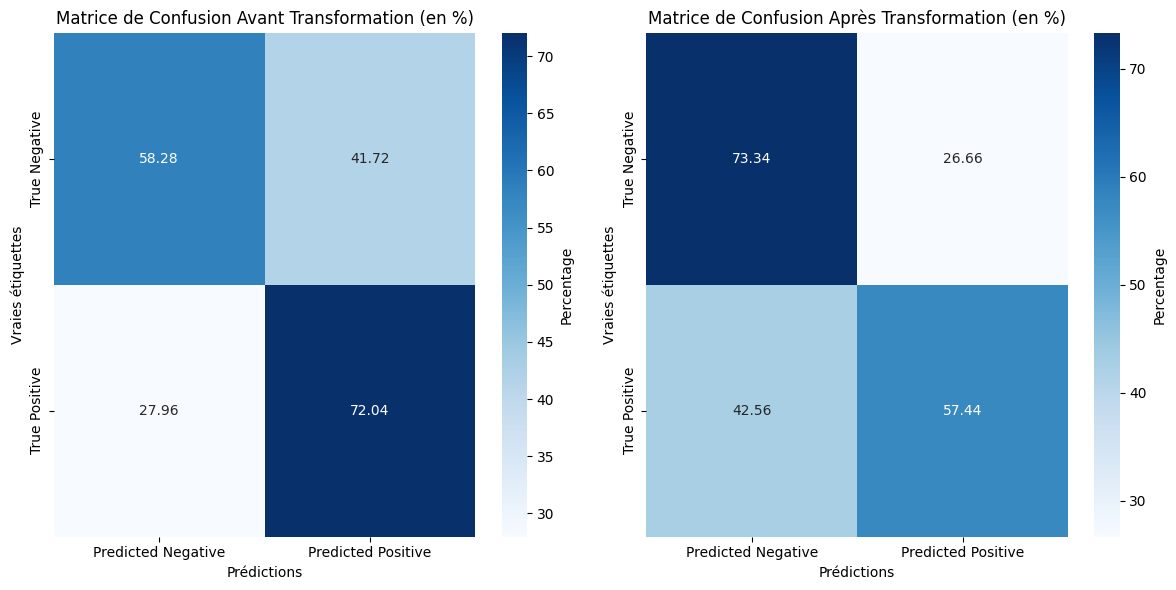

In [ ]:
%matplotlib inline

# Matrice de confusion avant et après transformation
conf_matrix_orig = confusion_matrix(test_dataset.labels, test_with_preds.labels)
conf_matrix_transf = confusion_matrix(test_dataset.labels, transformed_dataset.labels)

# Normalisation en pourcentages
conf_matrix_orig_percentage = conf_matrix_orig / conf_matrix_orig.sum(axis=1)[:, np.newaxis] * 100
conf_matrix_transf_percentage = conf_matrix_transf / conf_matrix_transf.sum(axis=1)[:, np.newaxis] * 100

# Création des heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Heatmap avant transformation (en pourcentages)
sns.heatmap(conf_matrix_orig_percentage, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["True Negative", "True Positive"], ax=axes[0], cbar_kws={'label': 'Percentage'})
axes[0].set_title('Matrice de Confusion Avant Transformation (en %)')
axes[0].set_xlabel('Prédictions')
axes[0].set_ylabel('Vraies étiquettes')

# Heatmap après transformation (en pourcentages)
sns.heatmap(conf_matrix_transf_percentage, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["True Negative", "True Positive"], ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('Matrice de Confusion Après Transformation (en %)')
axes[1].set_xlabel('Prédictions')
axes[1].set_ylabel('Vraies étiquettes')

# Affichage
plt.tight_layout()
plt.show()


In [ ]:
# Calcul des métriques
metric_orig = ClassificationMetric(test_dataset, test_with_preds,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

metric_transf = ClassificationMetric(test_dataset, transformed_dataset,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)


printMetrics(metric_orig,  metric_transf)



Métriques avant ROC:
Equal Opportunity Diff: -0.045244742648714364
Disparate Impact: 0.8218617343844754
Average Odds Difference: -0.06088635533205716
Theil Index: 0.287129076570245
Statistical Parity Difference: -0.08714677742342208
Error Rate: 0.35059482155353394
False Positive Rate: 0.2796242774566474
False Negative Rate: 0.41723202170963364
True Positive Rate: 0.5827679782903663
True Negative Rate: 0.7203757225433526

Métriques après ROC:
Equal Opportunity Diff: -0.012642410050884845
Disparate Impact: 0.9067975401373572
Average Odds Difference: -0.031017647479075844
Theil Index: 0.2010331270333095
Statistical Parity Difference: -0.05774864644366984
Error Rate: 0.34359692092372285
False Positive Rate: 0.42557803468208094
False Negative Rate: 0.2666214382632293
True Positive Rate: 0.7333785617367707
True Negative Rate: 0.5744219653179191


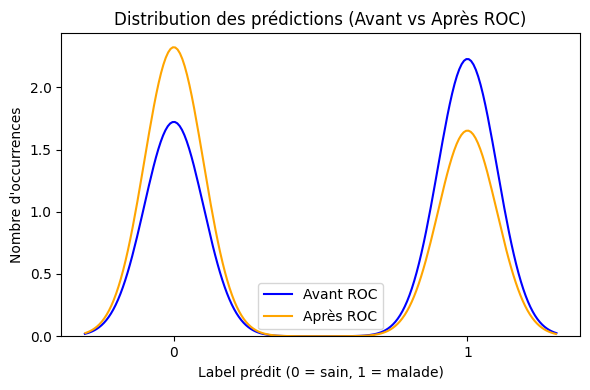

In [ ]:
%matplotlib inline
# Aplatir les tableaux au cas où
labels_before = test_with_preds.labels.ravel()
labels_after = transformed_dataset.labels.ravel()

# Tracer avec des histogrammes côte à côte
plt.figure(figsize=(6, 4))

sns.kdeplot(labels_before, color='blue', label='Avant ROC')
sns.kdeplot(labels_after, color='orange', label='Après ROC')


# Ajouter titres et légende propres
plt.title("Distribution des prédictions (Avant vs Après ROC)")
plt.xlabel("Label prédit (0 = sain, 1 = malade)")
plt.ylabel("Nombre d'occurrences")
plt.legend()
plt.xticks([0, 1])
plt.tight_layout()
plt.show()



#### Avec reweighing

In [ ]:
pred_rw = convert_all_to_numericals(pred_rw)

# Attribut protégé et groupes
protected_attribute = '+40ans'
privileged_groups = [{protected_attribute: 0}]
unprivileged_groups = [{protected_attribute: 1}]

# Créer les BinaryLabelDataset
test_dataset_rw = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=pred_rw.select_dtypes(include=['int64', 'float64']),
    label_names=["labels"],
    protected_attribute_names=[protected_attribute]
)

# Injecter prédictions et logits
test_with_preds = test_dataset_rw.copy()
test_with_preds.labels = pred_rw["preds"].values.reshape(-1, 1)
test_with_preds.scores = pred_rw["logits_1"].values.reshape(-1, 1)

In [ ]:
ROC = ROC.fit(test_dataset_rw, test_with_preds)
transformed_dataset = ROC.predict(test_with_preds)

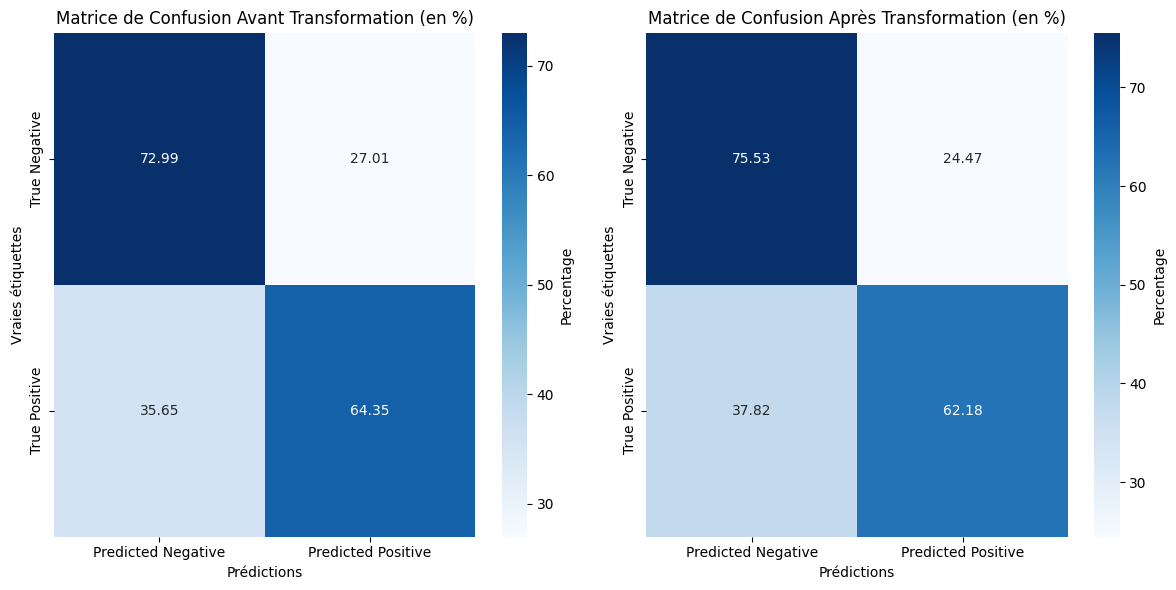

In [ ]:
%matplotlib inline

# Matrice de confusion avant et après transformation
conf_matrix_orig = confusion_matrix(test_dataset_rw.labels, test_with_preds.labels)
conf_matrix_transf = confusion_matrix(test_dataset_rw.labels, transformed_dataset.labels)

# Normalisation en pourcentages
conf_matrix_orig_percentage = conf_matrix_orig / conf_matrix_orig.sum(axis=1)[:, np.newaxis] * 100
conf_matrix_transf_percentage = conf_matrix_transf / conf_matrix_transf.sum(axis=1)[:, np.newaxis] * 100

# Création des heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Heatmap avant transformation (en pourcentages)
sns.heatmap(conf_matrix_orig_percentage, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["True Negative", "True Positive"], ax=axes[0], cbar_kws={'label': 'Percentage'})
axes[0].set_title('Matrice de Confusion Avant Transformation (en %)')
axes[0].set_xlabel('Prédictions')
axes[0].set_ylabel('Vraies étiquettes')

# Heatmap après transformation (en pourcentages)
sns.heatmap(conf_matrix_transf_percentage, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["True Negative", "True Positive"], ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('Matrice de Confusion Après Transformation (en %)')
axes[1].set_xlabel('Prédictions')
axes[1].set_ylabel('Vraies étiquettes')

# Affichage
plt.tight_layout()
plt.show()


In [ ]:
# Calcul des métriques
metric_orig = ClassificationMetric(test_dataset_rw, test_with_preds,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

metric_transf = ClassificationMetric(test_dataset_rw, transformed_dataset,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)

printMetrics(metric_orig,  metric_transf)  


Métriques avant ROC:
Equal Opportunity Diff: -0.03798869710972186
Disparate Impact: 0.954700138355406
Average Odds Difference: -0.002203244811188304
Theil Index: 0.20772642188781734
Statistical Parity Difference: -0.0261986336447253
Error Rate: 0.3090909090909091
False Positive Rate: 0.3564917966376342
False Negative Rate: 0.2701398135818908
True Positive Rate: 0.7298601864181092
True Negative Rate: 0.6435082033623658

Métriques après ROC:
Equal Opportunity Diff: -0.035397979523421164
Disparate Impact: 0.9612269023899338
Average Odds Difference: 0.0010084040651840986
Theil Index: 0.19256718702668918
Statistical Parity Difference: -0.023271838622146768
Error Rate: 0.3048880767473733
False Positive Rate: 0.3781648774559449
False Negative Rate: 0.24467376830892143
True Positive Rate: 0.7553262316910786
True Negative Rate: 0.621835122544055


In [ ]:
%matplotlib inline
# Aplatir les tableaux au cas où
labels_before = test_with_preds.labels.ravel()
labels_after = transformed_dataset.labels.ravel()

# Tracer avec des histogrammes côte à côte
plt.figure(figsize=(6, 4))

sns.kdeplot(labels_before, color='blue', label='Avant ROC')
sns.kdeplot(labels_after, color='orange', label='Après ROC')


# Ajouter titres et légende propres
plt.title("Distribution des prédictions (Avant vs Après ROC)")
plt.xlabel("Label prédit (0 = sain, 1 = malade)")
plt.ylabel("Nombre d'occurrences")
plt.legend()
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

C:\Users\zizou\AppData\Local\Temp\ipykernel_23080\4218898662.py:22: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



### b. Calibrated Equalized Odds

In [ ]:
def apply_CEO(test_dataset, priv_group=0, pos_label=1):
    cost_constraint = "fnr"  # ou "fpr", "weighted" selon ton critère d'équité

    # Postprocessing CEO
    ceo = CalibratedEqOddsPostprocessing(
        privileged_groups=[{protected_attribute: priv_group}],
        unprivileged_groups=[{protected_attribute: 1 - priv_group}],
        cost_constraint=cost_constraint,
        seed=42
    )

    # On considère test_dataset comme les prédictions (avec .scores et .labels modifiés)
    pred_dataset = test_dataset.copy()

    # Fit + Predict
    ceo = ceo.fit(test_dataset, pred_dataset)
    postproc_preds = ceo.predict(pred_dataset)

    # Calcul des métriques de fairness
    metrics = get_group_metrics(
        y_true=test_dataset.labels[:, 0],
        y_pred=postproc_preds.labels[:, 0],
        prot_attr=test_dataset.protected_attributes[:, 0],
        priv_group=priv_group,
        pos_label=pos_label
    )

    # Convertir les métriques en float
    metrics_float = {metric: float(value) for metric, value in metrics.items()}

    return metrics_float


In [ ]:
apply_CEO(test_dataset)

{'base_rate': 0.4842547235829251,
 'statistical_parity_difference': 0.09198826505805668,
 'disparate_impact_ratio': 1.2148969553457123,
 'equal_opportunity_difference': 0.0,
 'average_odds_difference': 0.0,
 'conditional_demographic_disparity': -0.01942114873792702,
 'smoothed_edf': 0.19448620588345744,
 'df_bias_amplification': 0.0}

In [ ]:
apply_CEO(test_dataset_rw)

{'base_rate': 0.45107354956601187,
 'statistical_parity_difference': 0.05199244774252049,
 'disparate_impact_ratio': 1.124519189387047,
 'equal_opportunity_difference': 0.0,
 'average_odds_difference': 0.0,
 'conditional_demographic_disparity': -0.013932334201692077,
 'smoothed_edf': 0.11731395832340319,
 'df_bias_amplification': 0.0}

---

## V. Analyse et compréhension

### -> Get together and link preproc and postproc results

---

## VI. Conclusion

### *Preferably*, get together and discuss final comments